<a href="https://colab.research.google.com/github/DaasDaham/Back-Propagation-Implementation/blob/main/BackPropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving val_set.pkl to val_set.pkl
Saving train_set.pkl to train_set.pkl


In [ ]:
import numpy as np
import math
from sklearn import datasets
import matplotlib
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import PIL
from sklearn.manifold import TSNE
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, multilabel_confusion_matrix
!matplotlib inline


class MLPClassifier:
    """
    My implementation of a Neural Network Classifier.
    """

    acti_fns = ["relu", "sigmoid", "linear", "tanh", "softmax"]
    avl_optims = ["adagrad", "gd", "gdm", "adam", "rmsprop","nestov"]

    def __init__(
        self,
        n_layers,
        layer_sizes,
        activation,
        learning_rate,
        batch_size,
        optimizer,
        num_epochs,
        scaling_factor=0.01,
        regularization="None",
        reg_param=0,
        initialization = 'random'
    ):
        """
        Initializing a new MyNeuralNetwork object

        Parameters
        ----------
        n_layers : int value specifying the number of layers

        layer_sizes : integer array of size n_layers specifying the number of nodes in each layer

        activation : string specifying the activation function to be used
                                 possible inputs: relu, sigmoid, linear, tanh

        learning_rate : float value specifying the learning rate to be used

        batch_size : int value specifying the batch size to be used

        num_epochs : int value specifying the number of epochs to be used
        """

        if activation not in self.acti_fns:
            raise Exception("Incorrect Activation Function")
        if optimizer not in self.avl_optims:
            raise Exception("Incorrect Optimizer")

        self.lr = learning_rate
        self.batch_size = batch_size
        self.n_layers = n_layers
        self.scaling_factor = scaling_factor

        # Initialize Weights
        self.weight_draw = self.random_init

        # Initialize activation function
        if activation == "sigmoid":
            self.afn = self.sigmoid
            self.d_afn = self.sigmoid_grad
        elif activation == "relu":
            self.afn = self.relu
            self.d_afn = self.relu_grad
        elif activation == "tanh":
            self.afn = self.tanh
            self.d_afn = self.tanh_grad

        self.regtype="None"
        if regularization == "l1":
            self.regtype = "l1"
            self.reg_lambda = reg_param
        if regularization == "l2":
            self.regtype = "l2"
            self.reg_lambda = reg_param
        if regularization == "dropout":
            self.keep_probs = reg_param
        # [784, 256, 128, 64, 10]
        self.layer_sizes = layer_sizes
        self.final_hidden_layer_tsne = []
        self.training_loss = []
        self.validation_loss = []
        self.num_epochs = num_epochs
        temp_layers = layer_sizes
        if initialization == 'xavier':
          temp_layers.insert(0, temp_layers[0])
          self.weights = np.array([
              np.random.normal(0, 1/math.sqrt(temp_layers[dims-1]), size = (temp_layers[dims+1], temp_layers[dims]))
              for dims in range(1, len(temp_layers)-1)
          ])
          temp_layers.pop(0)
        elif initialization == 'he':
          temp_layers.insert(0, temp_layers[0])
          self.weights = np.array([
              np.random.normal(0, math.sqrt(2/temp_layers[dims-1]), size = (temp_layers[dims+1], temp_layers[dims]))
              for dims in range(1, len(temp_layers)-1)
          ])
          temp_layers.pop(0)
        else:
          self.weights = np.array([
              self.weight_draw((layer_sizes[dims], layer_sizes[dims + 1]))
              for dims in range(len(layer_sizes) - 1)
          ])
        self.biases = np.array([np.zeros(shape=(dim, 1)) for dim in layer_sizes[1:]])
        self.usingadam = False
        if optimizer == "adagrad":
            self.optim = self.update_params_ada_grad
            self.Gwt = np.array([np.zeros_like(wt) for wt in self.weights])
            self.Gbt = np.array([np.zeros_like(bt) for bt in self.biases])
        elif optimizer == "gd":
            self.optim = self.update_params
        elif optimizer == "gdm":
            self.optim=self.update_params_grad_momentum
            self.vdw=np.array([np.zeros_like(wt) for wt in self.weights])
            self.vdb=np.array([np.zeros_like(bt) for bt in self.biases])
            self.beta=0.9
        elif optimizer == "nestov":
            self.optim = self.update_params_nestov_accelerated
            self.beta = 0.9
            self.vdw = np.array([np.zeros_like(wt) for wt in self.weights])
            self.vdb = np.array([np.zeros_like(bt) for bt in self.biases])
        elif optimizer == "rmsprop":
            self.optim=self.update_params_rms_prop
            self.sdw=np.array([np.zeros_like(wt) for wt in self.weights])
            self.sdb=np.array([np.zeros_like(bt) for bt in self.biases])
            self.beta=0.9
            self.epsilon=1.0e-8
        elif optimizer == "adam":
            self.usingadam = True
            self.optim= self.update_params_adam
            self.sdw=np.array([np.zeros_like(wt) for wt in self.weights])
            self.sdb=np.array([np.zeros_like(bt) for bt in self.biases])
            self.vdw=np.array([np.zeros_like(wt) for wt in self.weights])
            self.vdb=np.array([np.zeros_like(bt) for bt in self.biases])
            self.beta1=0.9
            self.beta2=0.999
            self.epsilon=1.0e-8


    def relu(self, X):
        """
        Calculating the ReLU activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        Z = np.copy(X)
        Z[Z < 0] = Z[Z < 0] * 0.01
        return Z

    def relu_grad(self, X):
        """
        Calculating the gradient of ReLU activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        dx = np.ones_like(X)
        dx[X < 0] = 0.01
        return dx

    def sigmoid(self, X):
        """
        Calculating the Sigmoid activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        return 1 / (1 + np.exp(-X))

    def sigmoid_grad(self, X):
        """
        Calculating the gradient of Sigmoid activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        tmp = 1 / (1 + np.exp(-X))
        return tmp * (1 - tmp)

    def tanh(self, X):
        """
        Calculating the Tanh activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        return (np.exp(X) - np.exp(-X)) / (np.exp(X) + np.exp(-X))

    def tanh_grad(self, X):
        """
        Calculating the gradient of Tanh activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        tmp = (np.exp(X) - np.exp(-X)) / (np.exp(X) + np.exp(-X))
        return 1 - tmp ** 2

    def softmax(self, X):
        """
        Calculating the ReLU activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        recenteredX = X - np.max(X)
        exps = np.exp(recenteredX)
        return exps / np.sum(exps)

    def batch_softmax(self, X):
        return np.array([self.softmax(row) for row in X])

    def softmax_grad(self, X):
        """
        Calculating the gradient of Softmax activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        s = self.softmax(X)
        s = s.reshape(-1,1)
        return np.diagflat(s) - np.dot(s, s.T)

    def batch_softmax_grad(self, X):
        s = self.batch_softmax(X)
        return np.array([self.softmax_grad(row) for row in s])

    def random_init(self, shape):
        """
        Calculating the initial weights after Random Activation for a particular layer

        Parameters
        ----------
        shape : tuple specifying the shape of the layer for which weights have to be generated

        Returns
        -------
        weight : 2-dimensional numpy array which contains the initial weights for the requested layer
        """
        return np.random.randn(shape[1], shape[0]) * self.scaling_factor

    def loss_fn(self, X, y):
        """
        X : training samples, shape (num_examples x num_classes)
        y : labels, shape = (num_examples x 1)
        returns multi class cross entropy loss
        """
        N = X.shape[0]
        ce = (-np.sum(y * np.log(X))) / N
        return ce

    def d_loss(self, X, y):
        """
        X: predictions from last layer after activating with either sigmoid or softmax
        y: corresponding outputs
        Returns: gradient for CE loss only when input is passed through sigmoid or softmax
        """
        return X - y

    def forward(self, X):
        """
        X: Input in shape: samples * features
        Returns: Outputs after forward prop
        """
        outputs = []
        for x in X:
            a = x.reshape(-1, 1)
            last_layer_check = 0
            last_layer_index = len(self.weights) - 1
            for wl, bl in zip(self.weights, self.biases):
                a = np.dot(wl, a) + bl
                if last_layer_check == last_layer_index:
                    a = self.softmax(a)
                else:
                    a = self.afn(a)
                last_layer_check += 1
            outputs.append(a.reshape(-1))
        return np.array(outputs)

    def back(self, X, y, batch_loss, fin_hidden_layer):
        """
        Back propogate and calculate Delta W and Delta B for a given mini-batch
        batch_loss: to calculate and store loss for the complete batch
        Implements Backprop algorithm
        """
        deltaW = np.copy(self.weights)
        deltaB = np.copy(self.biases)
        batch_size = X.shape[0]
        a = X
        pre_acts = [a]
        post_acts = [a]
        last_layer_check = 0
        last_layer_index = len(self.weights) - 1
        drop_prob_idx = 0
        for wl, bl in zip(self.weights, self.biases):
            bias_l_cp = np.copy(bl).reshape(-1)
            bias_l_cp = np.array(
                [
                    bias_l_cp,
                ]
                * batch_size
            )
            a = a.dot(wl.T) + bias_l_cp
            pre_acts.append(a)
            if last_layer_check == last_layer_index:
                a = self.batch_softmax(a)
            else:
                a = self.afn(a)
                if self.regtype=="dropout":
                    curr_mask = (np.random.rand(a.shape[0], a.shape[1]) < self.keep_probs[drop_prob_idx])/self.keep_probs[drop_prob_idx]
                    a = np.multiply(a, curr_mask)
                    drop_prob_idx += 1
            post_acts.append(a)
            last_layer_check += 1
        loss = self.loss_fn(post_acts[-1], y)
        batch_loss.append(loss)
        last_layer_loss = self.d_loss(post_acts[-1], y).reshape(y.shape[0], 1, y.shape[1])
        last_layer_loss_gd = np.matmul(last_layer_loss, self.batch_softmax_grad(pre_acts[-1]))
        last_layer_loss_gd = np.squeeze(last_layer_loss_gd)
        deltaW[-1] = (last_layer_loss_gd.T).dot(post_acts[-2])
        deltaB[-1] = np.sum(last_layer_loss_gd, axis=0).reshape(-1, 1)
        curr_layer_gd = last_layer_loss_gd
        for curr_layer_id in range(len(self.layer_sizes) - 2, 0, -1):
            curr_layer_gd = curr_layer_gd.dot(self.weights[curr_layer_id]) * self.d_afn(
                pre_acts[curr_layer_id]
            )
            deltaW[curr_layer_id - 1] = (curr_layer_gd.T).dot(
                post_acts[curr_layer_id - 1]
            )
            deltaB[curr_layer_id - 1] = np.sum(curr_layer_gd, axis=0).reshape(-1, 1)
        return deltaW, deltaB

    def combine(self, X, y):
        """
        Function: To combine two Arrays X and y along column
        """
        y_shape = y.shape[1]
        data = np.concatenate((X, y), axis=1)
        return data

    def get_x_y(self, data, y_shape):
        """
        Performs the opposite function of combine function
        Splits X and y from combined data
        Arguments:
        data = Combined data to be splitted
        y_shape = number of columns required to be splitted
        """
        y = data[:, -y_shape : data.shape[1]]
        x = data[:, :-y_shape]
        return x, y        
        

    def update_params_grad_momentum(self, X_train_batch, y_train_batch, lr):
        """
        Update weights and Biases using backprop
        lr: learning rate
        returns: average batch loss and final hidden layer ouput used for TSNE plot
        """
        batch_loss = []
        fin_hidden_layer = []
        delta_W, delta_b = self.back(
            X_train_batch, y_train_batch, batch_loss, fin_hidden_layer
        )
        """Have to be initialzed from start
        self.optim=self.update_params_grad_momentum
        self.vdw=np.zeros_like(delta_W)
        self.vdb=np.zeros_like(delta_b)
        self.beta=0.9

        """
        if self.regtype == "l1":
            delta_W = [dW+(np.sign(W)*self.reg_lambda) for dW, W in zip(delta_W, self.weights)]
        if self.regtype == "l2":
            delta_W = [dW+((2*self.reg_lambda)*W) for dW, W in zip(delta_W, self.weights)]

        self.vdw= [self.beta*vd+(1-self.beta)*dw for vd,dw in zip(self.vdw,delta_W)]
        self.vdb= [self.beta*vd+(1-self.beta)*db for vd,db in zip(self.vdb,delta_b)]

        self.weights = [W - (lr* dW) for W,dW in zip(self.weights, self.vdw)]
        self.biases = [b - (lr* db) for b,db in zip(self.biases, self.vdb)]
        return np.average(batch_loss), fin_hidden_layer
      
    def update_params_rms_prop(self, X_train_batch, y_train_batch, lr):
        """
        Update weights and Biases using backprop
        lr: learning rate
        returns: average batch loss and final hidden layer ouput used for TSNE plot
        """
        batch_loss = []
        fin_hidden_layer = []
        delta_W, delta_b = self.back(
            X_train_batch, y_train_batch, batch_loss, fin_hidden_layer
        )
        
        """Will be used in initialization
        self.optim=self.update_params_rms_prop
        self.sdw=np.zeros_like(self.weights)
        self.sdb=np.zeros_like(self.biases)
        self.beta=0.9
        self.epsilon=1.0e-8
        """

        dw_sq= np.square(delta_W)
        db_sq= np.square(delta_b)

        self.sdw= [self.beta*sd+(1-self.beta)*dwsq for sd,dw,dwsq in zip(self.sdw,delta_W,dw_sq)]
        self.sdb= [self.beta*sd+(1-self.beta)*dbsq for sd,db,dbsq in zip(self.sdb,delta_b,db_sq)]

        self.weights = [W -((lr* dW)/(np.sqrt(dws)+self.epsilon)) for W,dws,dW in zip(self.weights, self.sdw,delta_W)]
        self.biases = [b - ((lr* db)/(np.sqrt(dbs)+self.epsilon)) for b,dbs,db in zip(self.biases, self.sdb,delta_b)]
        return np.average(batch_loss), fin_hidden_layer

    def update_params_adam(self, X_train_batch, y_train_batch, lr, epoch):
        """
        Update weights and Biases using backprop
        lr: learning rate
        returns: average batch loss and final hidden layer ouput used for TSNE plot
        """
        batch_loss = []
        fin_hidden_layer = []
        delta_W, delta_b = self.back(
            X_train_batch, y_train_batch, batch_loss, fin_hidden_layer
        )

        """
        
        Will be initiliazed at the init
        sdw=np.zeros_like(delta_W)
        sdb=np.zeros_like(delta_b)
        vdw=np.zeros_like(delta_W)
        vdb=np.zeros_like(delta_b)
        
        beta1=0.9
        beta2=0.999
        epsilon=1.0e-8

        """

        dw_sq= np.square(delta_W)
        db_sq= np.square(delta_b)

        self.vdw= [(self.beta1*vd)+((1-self.beta1)*dw) for vd,dw in zip(self.vdw,delta_W)]
        self.vdb= [(self.beta1*vd)+((1-self.beta1)*db) for vd,db in zip(self.vdb,delta_b)]

        self.sdw= [(self.beta2*sd)+((1-self.beta2)*dwsq) for sd,dw,dwsq in zip(self.sdw,delta_W,dw_sq)]
        self.sdb= [(self.beta2*sd)+((1-self.beta2)*dbsq) for sd,db,dbsq in zip(self.sdb,delta_b,db_sq)]

        first_den = (1-(self.beta1**epoch))
        second_den = (1-(self.beta2**epoch))

        # self.vdw= [vd/first_den for vd in self.vdw]
        # self.vdb= [vd/first_den for vd in self.vdb]

        # self.sdw= [sd/second_den for sd in self.sdw]
        # self.sdb= [sd/second_den for sd in self.sdb]

        self.weights = [W -((lr* dwv)/(np.sqrt(dws)+self.epsilon)) for W,dws,dwv in zip(self.weights, self.sdw,self.vdw)]
        self.biases = [b - ((lr* dbv)/(np.sqrt(dbs)+self.epsilon)) for b,dbs,dbv in zip(self.biases, self.sdb,self.vdb)]
        return np.average(batch_loss), fin_hidden_layer

    def update_params_nestov_accelerated(self, X_train_batch, y_train_batch, lr, epsilon=1e-8):
        """
        Update weights and Biases using backprop
        lr: learning rate
        returns: average batch loss and final hidden layer ouput used for TSNE plot
        """
        batch_loss = []
        fin_hidden_layer = []

        self.weights = np.array([wt - self.beta*vw for wt, vw in zip(self.weights, self.vdw)])
        self.biases = np.array([bt - self.beta*vb for bt, vb in zip(self.biases, self.vdb)])

        delta_W, delta_b = self.back(
            X_train_batch, y_train_batch, batch_loss, fin_hidden_layer
        )

        #backpropgation
        vdw = np.array([self.beta*vw + lr*dw for vw, dw in zip(self.vdw, delta_W)])
        vdb = np.array([self.beta*vb + lr*db for vb, db in zip(self.vdb, delta_b)])

        self.weights = np.array([wt - self.beta*vw - vw for wt, vw in zip(self.weights, self.vdw)])
        self.biases = np.array([bt - self.beta*vb -vb for bt, vb in zip(self.biases, self.vdb)])

        # self.weights = self.weights + self.beta*self.vdw-vdw
        # self.biases = self.biases + self.beta*self.vdb - vdb
        self.vdw = vdw 
        self.vdb = vdb
        ###
        return np.average(batch_loss), fin_hidden_layer

    def update_params_ada_grad(self, X_train_batch, y_train_batch, lr, epsilon=1e-8):
        """
        Update weights and Biases using backprop
        lr: learning rate
        returns: average batch loss and final hidden layer ouput used for TSNE plot
        """
        batch_loss = []
        fin_hidden_layer = []
        delta_W, delta_b = self.back(
            X_train_batch, y_train_batch, batch_loss, fin_hidden_layer
        )
        for i in range(len(delta_W)):
            self.Gwt[i] = self.Gwt[i]+delta_W[i]**2
        for i in range(len(delta_b)):
            self.Gbt[i] = self.Gbt[i]+delta_b[i]**2
        
        temp_gwt = [lr/np.sqrt(G+epsilon) for G in self.Gwt]
        temp_gbt = [lr/np.sqrt(B+epsilon) for B in self.Gbt]

        self.weights = [W - (Gii * dW) for W, Gii, dW in zip(self.weights, temp_gwt, delta_W)]
        self.biases = [b - (Gii * db) for b, Gii, db in zip(self.biases, temp_gbt, delta_b)]
        return np.average(batch_loss), fin_hidden_layer

    def update_params(self, X_train_batch, y_train_batch, lr):
        """
        Update weights and Biases using backprop
        lr: learning rate
        returns: average batch loss and final hidden layer ouput used for TSNE plot
        """
        batch_loss = []
        fin_hidden_layer = []
        delta_W, delta_b = self.back(
            X_train_batch, y_train_batch, batch_loss, fin_hidden_layer
        )
        self.weights = [
            W - (lr * dW / len(X_train_batch)) for W, dW in zip(self.weights, delta_W)
        ]
        self.biases = [
            b - (lr * db / len(X_train_batch)) for b, db in zip(self.biases, delta_b)
        ]
        return np.average(batch_loss), fin_hidden_layer

    def fit(self, X, y, X_val=[], y_val=[]):
        """
        Fitting (training) the linear model.

        Parameters
        ----------
        X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as training data.

        y : 1-dimensional numpy array of shape (n_samples,) which acts as training labels.

        Returns
        -------
        self : an instance of self
        """
        y_shape = y.shape[1]
        for epoch in range(self.num_epochs):
            data = self.combine(X, y)
            np.random.shuffle(data)
            folds = np.array_split(data, data.shape[0] / self.batch_size)
            temp_loss = []
            for i in range(len(folds)):
                X_train_batch, y_train_batch = self.get_x_y(folds[i], y_shape)
                if self.usingadam == True:
                    batch_loss, fin_hidden_layer = self.update_params_adam(
                        X_train_batch, y_train_batch, self.lr, (epoch+1)
                    )
                else:
                    batch_loss, fin_hidden_layer = self.optim(
                        X_train_batch, y_train_batch, self.lr
                    )
                temp_loss.append(batch_loss)
            self.training_loss.append(np.average(temp_loss))
            val_error = self.get_error(X_val, y_val)
            self.validation_loss.append(val_error)
            val_accuracy = self.score(X_val, y_val)
            print(
                "Epoch {0}: Validation Accuracy: {1:.2f}, Training Loss: {2}, Validation Loss {3}".format(
                    epoch + 1, val_accuracy, self.training_loss[-1], val_error
                )
            )
        return self

    def get_error(self, X, y):
        """
        Used to get CE error
        """
        y_pred = self.forward(X)
        error = self.loss_fn(y_pred, y)
        return error

    def predict_proba(self, X):
        """
        Predicting probabilities using the trained linear model.

        Parameters
        ----------
        X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as testing data.

        Returns
        -------
        y : 2-dimensional numpy array of shape (n_samples, n_classes) which contains the
                class wise prediction probabilities.
        """
        # return the numpy array y which contains the predicted values
        y_pred_probs = self.forward(X)
        return y_pred_probs

    def predict(self, X):
        """
        Predicting values using the trained linear model.

        Parameters
        ----------
        X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as testing data.

        Returns
        -------
        y : 1-dimensional numpy array of shape (n_samples,) which contains the predicted values.
        """
        # return the numpy array y which contains the predicted values
        y_pred = self.forward(X)
        y_pred = np.argmax(y_pred, axis=1)
        return y_pred

    def get_params(self):
        return self.weights, self.biases
     
    def plot_roc(self, X_test, y_test, plot_name):
        y_probs = self.predict_proba(X_test)
        for i in range(10):
            lr_fpr, lr_tpr, _ = roc_curve(y_test[:,i],y_probs[:,i])
            plt.plot(lr_fpr, lr_tpr, marker='.', label='Number-'+str(i))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.savefig(plot_name+".png")

    def plot_losses(self, hidden_layer_afn, optimizer_name, plot_name):
        epochs = np.arange(self.num_epochs)
        train_losses = self.training_loss
        test_loss = self.validation_loss
        fig, ax = plt.subplots(figsize=(12,6.5))
        plt.plot(epochs, train_losses, label="Training loss")
        plt.plot(epochs, test_loss, label="Validation Loss")
        ax.legend()
        plt.title("Train, Validation loss | {} | {}".format(hidden_layer_afn, optimizer_name))
        plt.xlabel('Iterations')
        plt.ylabel('Training Loss, Validation Loss')
        plt.savefig(plot_name+".png")
        plt.close()

    def plot_confusion_matrix(self, X_test, y_test, plot_name):
        y_pred = self.predict(X_test)
        cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
        print(cm)
        cmd = ConfusionMatrixDisplay(cm, display_labels=['0','1','2','3','4','5','6','7','8','9'])
        cmd.plot()
        plt.savefig(plot_name+".png")
        plt.close()

    def score(self, X, y):
        """
        Predicting values using the trained linear model.

        Parameters
        ----------
        X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as testing data.

        y : 1-dimensional numpy array of shape (n_samples,) which acts as testing labels.

        Returns
        -------
        acc : float value specifying the accuracy of the model on the provided testing set
        """
        # return the numpy array y which contains the predicted values
        pred = self.forward(X)
        return np.sum(np.argmax(y, axis=1) == np.argmax(pred, axis=1)) / len(y)


/bin/bash: matplotlib: command not found


In [ ]:
train = np.load('train_set.pkl', allow_pickle=True)
test = np.load('val_set.pkl', allow_pickle=True)
X_train = np.array([(np.array(i).flatten())/255 for i in train.iloc[:,0]])
enc = OneHotEncoder()
y_train = enc.fit_transform(np.array(train.iloc[:,1]).reshape(-1,1)).toarray()
X_val = X_train[9000:]
y_val = y_train[9000:]
X_train = X_train[:9000]
y_train = y_train[:9000]
X_test = np.array([(np.array(i).flatten())/255 for i in test.iloc[:,0]])
enc = OneHotEncoder()
y_test = enc.fit_transform(np.array(test.iloc[:,1]).reshape(-1,1)).toarray()

In [ ]:
# Instantiating MLPClassifier class
mlp = MLPClassifier(5, [784, 256, 128, 64, 10], "relu", 0.01, 64,"gdm", 100, scaling_factor=0.1, regularization="dropout", reg_param=[0.2,0.2,0.2], initialization="xavier") 
mlp.fit(X_train, y_train, X_val, y_val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:119: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/lo

(256, 784) Weights
(128, 256) Weights
(64, 128) Weights
(10, 64) Weights
Epoch 1: Validation Accuracy: 0.43, Training Loss: 2.1630961368404535, Validation Loss 1.847174173170763
Epoch 2: Validation Accuracy: 0.76, Training Loss: 0.8160707448466026, Validation Loss 0.6822289701923832
Epoch 3: Validation Accuracy: 0.87, Training Loss: 0.43564624758848236, Validation Loss 0.4342180550120704
Epoch 4: Validation Accuracy: 0.88, Training Loss: 0.35404877169787197, Validation Loss 0.3992990332285246
Epoch 5: Validation Accuracy: 0.91, Training Loss: 0.2849591042580806, Validation Loss 0.3345091316522048
Epoch 6: Validation Accuracy: 0.92, Training Loss: 0.24564567309346166, Validation Loss 0.26059634889778044
Epoch 7: Validation Accuracy: 0.92, Training Loss: 0.20410739189371455, Validation Loss 0.27431245693663675
Epoch 8: Validation Accuracy: 0.93, Training Loss: 0.17649717435966591, Validation Loss 0.25643409552301727
Epoch 9: Validation Accuracy: 0.93, Training Loss: 0.1493881460602113, V

In [ ]:
import dill
afn_name = "xavier_dropout_0_2"
opt_name = "gdm_relu_xavier_dropout_0_2"
with open('MLP_{}_{}.pkl'.format(opt_name, afn_name), 'wb') as f:
    dill.dump(mlp, f)


[[194   0   1   0   1   0   2   0   1   1]
 [  0 196   1   1   0   0   0   0   2   0]
 [  1   0 186   1   0   0   5   3   3   1]
 [  0   0   4 187   0   2   0   5   1   1]
 [  1   0   1   0 186   0   5   0   0   7]
 [  1   0   0   6   4 177   3   1   7   1]
 [  3   2   3   0   6   3 181   0   1   1]
 [  0   3   5   2   1   0   0 183   0   6]
 [  1   2   5   5   2   1   1   2 177   4]
 [  1   0   0   1   3   1   0   4   6 184]]


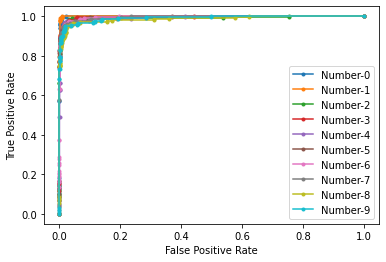

In [ ]:
mlp.plot_roc(X_test, y_test, "{}_{}_ROC".format(opt_name, afn_name))
mlp.plot_losses(hidden_layer_afn="{}".format(opt_name, afn_name), optimizer_name="{}".format(opt_name), plot_name="{}_{}_Losses".format(opt_name, afn_name))
mlp.plot_confusion_matrix(X_test, y_test, "{}_{}_CM".format(opt_name, afn_name))

[[187   0   2   3   1   5   2   0   0   0]
 [  0 192   1   2   0   1   1   0   3   0]
 [  1   2 160   9   0   1   6   5  13   3]
 [  0   0   1 169   0  10   2   6  10   2]
 [  0   1   1   0 153   0   7   2   1  35]
 [  4   0   0  29   3 118   7  11  17  11]
 [  8   2   9   1   9   7 158   0   6   0]
 [  1  10   8   1   2   0   0 160   4  14]
 [  3   1   8  14   3   4   2   3 149  13]
 [  1   1   0  10   5   0   0   3   4 176]]
